In [1]:
from songs import *

# НЕЙРОНКИ

In [2]:
import numpy as np
from numpy import random
import queue
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MEMORY_TIMES = 64
STARTER = 8

ADDITIONAL_MEMORY = 8

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY

In [4]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]
NAMES = []
for i in range(8):
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [5]:
class Edge:
    def __init__(self, inp, outp, w, was_right=[1, 1], precedents=[2, 2]):
        self.input = inp
        self.output = outp
        self.weight = w
        
        self.was_right = was_right[:]
        self.precedents = precedents[:]
        
    def quality(self, emitted):
        return self.was_right[emitted == 1] / self.precedents[emitted == 1]

IDS = 0
class Neuron:
    def __init__(self, index, bias=0, name="", is_base=False):
        self.name = name
        if not is_base:
            global IDS
            self.name += str(IDS)
            IDS += 1
        
        self.index = index
        self.is_base = is_base
        
        self.inputs = []
        self.outputs = []
        self.signal = 0
        self.bias = bias
        
        self.emited = 1
        self.used = 2
        
        self.signal_quality = 1
        self.success = False       
        
    def initialize(self):
        self.signal = self.bias
        self.signal_quality = 1
        self.success = False
        
    def emit(self, neurons):
        self.used += 1
        if self.signal > 0:
            self.emited += 1
        
        for edge in self.outputs:
            edge.output.signal += edge.weight * self.emitted()
            edge.output.signal_quality = min(edge.output.signal_quality,
                                            edge.quality(self.emitted()) * self.signal_quality)
            
    def emitted(self):
        if self.signal > 0:
            return 1
        return -1            
                
    def reward(self, true_val):  # оценивание связей
        decision = self.signal > 0  # был ли включён этот нейрон
        
        if decision == true_val:  # если выдал нужный сигнал, добавляем в список молодцев
            self.success = True
                   
        for edge in self.inputs:
            input_val = edge.input.signal > 0  # входной сигнал
            if input_val == decision:  # интересная эвристика: оцениваем только когда решение было за нейроном
                edge.precedents[input_val == 1] += 1
                if input_val == true_val:
                    edge.was_right[input_val == 1] += 1
                
                edge.input.reward(true_val)  # переходим во вход рекурсивно

In [248]:
class Func:
    def __init__(self):
        global IDS
        IDS = 0
        
        self.neurons = [Neuron(i, name=NAMES[i], is_base=True) for i in range(MEMORY_SIZE)]  # входы
        for i in range(13):                                               # выходы
            self.neurons.append(Neuron(MEMORY_SIZE + i, name=NOTE_NAMES[i] + "outp", is_base=True)) 
        
        self.Random = np.random.RandomState(seed=179)        
        self.verbose = False
        self.depth = ""
        
    def apply(self, x):  # проход по нейросети
        for neuron in self.neurons:
            neuron.initialize()
            
        for i, val in enumerate(x):  # посылаем сигналы на нужные входы
            if val == 1:
                self.neurons[i].signal += 1
                
        for N in self.neurons:
            N.emit(self.neurons)
        
        # собираем включившиеся выходы
        return np.array([self.neurons[-13+i].signal > 0 for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            self.neurons[-13+i].reward(val)
            
    def forget_info(self):
        for N in self.neurons:
            for edge in N.inputs:
                edge.was_right = [1, 1]
                edge.precedents = [2, 2]
            N.emited = 1
            N.used = 2
    
    def randomOne(self, conseq):
        candidates = []
        proba = []
        sum_p = 0
        for N in self.neurons[:min(len(self.neurons) - 13, conseq.index)]:
            candidates.append(N)
            if N.signal > 0:# and not N in conseq.inputs:
                proba.append(1 - N.emited / N.used)
            else:
                proba.append(N.emited / N.used)
                
        proba = np.array(proba)
        proba /= proba.sum()
        return self.Random.choice(candidates, p=proba)
    
    def connect(self, N1, N2, w, was_right=[1, 2], precedents=[2, 3]):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        #if N1 in N2.inputs:
        #    if self.verbose:
        #        print(self.depth, "tried to create existing edge, procedure failed")
        #    return False
        
        if self.verbose:
            print(self.depth, "new edge (w=" + str(w) + ") between layers: ", N1.name, "(", N1.index, ")", " / ", N2.name, "(", N2.index, ")")
        NewEdge = Edge(N1, N2, w, was_right, precedents)
        N1.outputs.append(NewEdge)
        N2.inputs.append(NewEdge)
        return True
    
    def check_for_blow(self, neurons_queue):
        while not neurons_queue.empty():
            N = neurons_queue.get()
            
            # проверяем нейрон; если у него нет входов или выходов, взрываем
            if N in self.neurons and not N.is_base: #возможно, он уже взорван
                if len(N.outputs) == 0:
                    if self.verbose:
                        print(self.depth, "neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.inputs[:]:
                        self.disconnect(edge, neurons_queue)
                elif len(N.inputs) == 0:
                    if self.verbose:
                        print(self.depth, "neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.outputs[:]:
                        self.disconnect(edge, neurons_queue)
                else:
                    continue
                
                for neuron in self.neurons[N.index:]:
                    neuron.index -= 1
                self.neurons.remove(N)
    def disconnect(self, edge, neurons_queue=None):
        # разъединяем связь
        if self.verbose:
            print(self.depth, "remove edge between layers: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        edge.output.inputs.remove(edge)
        edge.input.outputs.remove(edge)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать
        if neurons_queue is None:
            neurons_queue = queue.Queue()
        neurons_queue.put(edge.input)
        neurons_queue.put(edge.output)
        return neurons_queue
        
    def add_stub(self, edge, wish):
        # добавление заглушки
        stub_index = 1 + self.Random.randint(max(edge.input.index, MEMORY_SIZE - 1), min(len(self.neurons) - 13, edge.output.index))
        
        #mirror = self.Random.randint(0, 2)*2 - 1
        
        stub = Neuron(stub_index)
        for neuron in self.neurons[stub_index:]:
            neuron.index += 1
        self.neurons.insert(stub_index, stub)

        stub.signal = 1
        stub.signal_quality = edge.input.signal_quality * 0.66
        
        if self.verbose:
            print(self.depth, "created stub (", stub_index, ") between: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        
        # оценки связей берём из разорванной связи
        self.connect(edge.input, stub, edge.weight*(-wish), edge.was_right, edge.precedents)
        self.connect(stub, edge.output, -wish, edge.was_right, edge.precedents)
        self.disconnect(edge)
        
        return stub
        
    def turn(self, N, wish, TAME=None, no_recursion=False):
        # АЛГОРИТМ ПОПРАВКИ!
        self.depth += "    "
        
        if TAME is None:
            TAME = N.signal_quality
        
        # Если мы оказались на входе, то сразу говорим, что ничего не вышло
        if N.index < MEMORY_SIZE:
            if self.verbose:
                print(self.depth, N.name, " is input neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False
        
        # если этот нейрон выдал правильный сигнал хоть для какого-то выхода, его не трогаем
        if N.success:
            if self.verbose:
                print(self.depth, N.name, " is success neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False            
        
        votes = N.signal        
        if self.verbose:
            print(self.depth, "turning ", wish, ": ", N.name, " votes = ", votes, ", q = ", N.signal_quality)
            
        if N.emitted() == wish:
            print("ERROR! wish and signal are EQUAL!")
        
        error = votes
        if wish == 1:
            error = 1 - votes
        
        if not no_recursion and len(N.inputs) > 0:  # запрет на рекурсию выставляется в том случае, если мы правим новую заглушку
            edges = N.inputs[:]
            #self.Random.shuffle(edges)
            edges = np.array(edges)[np.argsort([edge.quality(edge.input.emitted() * edge.weight) * edge.input.signal_quality for edge in edges])]
            for edge in edges:
                emitted = edge.input.emitted() * edge.weight
                if edge in N.inputs and emitted != wish:  # перебираем входы с неверным пришедшим сигналом
                    if edge.input.index >= N.index:
                        print("ERROR FATAL CYCLE!")
                    
                    decision = self.Random.choice(["wrong input", "wrong edge", "wrong everything", "is ok"],
                                                 p=[
                                                     (1 - edge.input.signal_quality) * edge.quality(emitted),
                                                     (1 - edge.quality(emitted)) * edge.input.signal_quality,                                                     
                                                     (1 - edge.quality(emitted)) * (1 - edge.input.signal_quality),
                                                     edge.quality(emitted) * edge.input.signal_quality
                                                   ])
                    if decision == "wrong input":
                        result = self.turn(edge.input, edge.weight * wish, TAME)                  
                            
                        # если исправить вход не получилось, да ну его нафиг                        
                        if not result:
                            self.check_for_blow(self.disconnect(edge))
                            votes += wish
                        else:
                            votes += (1 + (edge in N.inputs)) * wish
                    elif decision == "wrong edge":                        
                        stub = self.add_stub(edge, wish)

                        result = self.turn(stub, -1, TAME, no_recursion=True)
                        if result:
                            votes += 2*wish
                        else:
                            print("WTF")
                    elif decision == "wrong everything":
                        break
                        
                    #elif self.Random.uniform(0, 1) > edge.quality(emitted):
                    #    self.check_for_blow(self.disconnect(edge))
                    #    votes += wish
                        
                    # нейрон, в котором мы сейчас сидим, может взорваться по цепочке;
                    # в таком случае, алгоритм типауспешно заканчивается
                    if not N in self.neurons:
                        if self.verbose:
                            print(self.depth, "we blowed up!")
                        self.depth = self.depth[:-4]
                        return True
        
        # результат процедуры           
        error = votes
        if wish == 1:
            error = 1 - votes
        
        # если проход по связям не удался, надо добавлять новые связи
        if error == 1:
            if self.verbose:
                print(self.depth, "didn't fix voting situation... (" + str(votes) + ")")
            
            one = self.randomOne(N)
            self.connect(one, N, wish * one.emitted())
            votes += wish
             
        # итоговый результат
        new_pos = -1
        if votes > 0:
            new_pos = 1          
        
        if new_pos == wish:
            N.success = True
        elif self.verbose:
            print(self.depth, "procedure failed")
        self.depth = self.depth[:-4]
        return new_pos == wish
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            if N.index < MEMORY_SIZE:
                dot.attr('node', shape='doublecircle')
            elif N.is_base:
                dot.attr('node', shape='circle', color='green')
            else:
                dot.attr('node', style='filled', color='lightblue')
                
            if len(N.outputs) > 0 or len(N.inputs) > 0:
                dot.node(label = N.name + "\nq={0:.2f},".format(N.signal_quality) + "\ne={0:.3f}".format(N.emited / N.used), 
                         name = N.name, size='2')
        
        for N in self.neurons:
            for edge in N.inputs:
                c = "blue"
                if edge.weight == -1:
                    c = "red"
                dot.edge(edge.input.name, edge.output.name, color = c, label = "{0:.2f}".format(edge.quality(0))  + "/" + "{0:.2f}".format(edge.quality(1)))
        #dot.render(view=True)
        return dot

In [249]:
class Player:
    def __init__(self):
        self.play_note = Func()
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[-13 + note], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[-13 + note], -1)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [250]:
player = Player()

In [251]:
kuznechik = Song('../basic midi/track (1).mid')

In [252]:
player.learn_to_play(kuznechik, verbose=True, limit=69)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  Aoutp  votes =  0 , q =  1
     didn't fix voting situation... (0)
     new edge (w=-1) between layers:  A#-4 ( 798 )  /  Aoutp ( 849 )
[0 0 0 0 0 0 0 0 0 1 0 0 0]
     turning  -1 :  Aoutp  votes =  1 , q =  0.5
     created stub ( 840 ) between:  A#-4 ( 798 )  /  Aoutp ( 850 )
     new edge (w=-1) between layers:  A#-4 ( 798 )  /  0 ( 840 )
     new edge (w=1) between layers:  0 ( 840 )  /  Aoutp ( 850 )
     remove edge between layers:  A#-4 ( 798 )  /  Aoutp ( 850 )
         turning  -1 :  0  votes =  1 , q =  0.66
         didn't fix voting situation... (1)
         new edge (w=1) between layers:  C^-9 ( 735 )  /  0 ( 840 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp  votes =  0 , q =  1
     didn't fix voting situation... (0)
     new edge (w=-1) between layers:  E-13 ( 675 )  /  G#outp ( 849 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
     turning  -1 :  G#outp  votes =  1 , q =  0.5
     didn't fix voting situation... (1)
     new edge

33

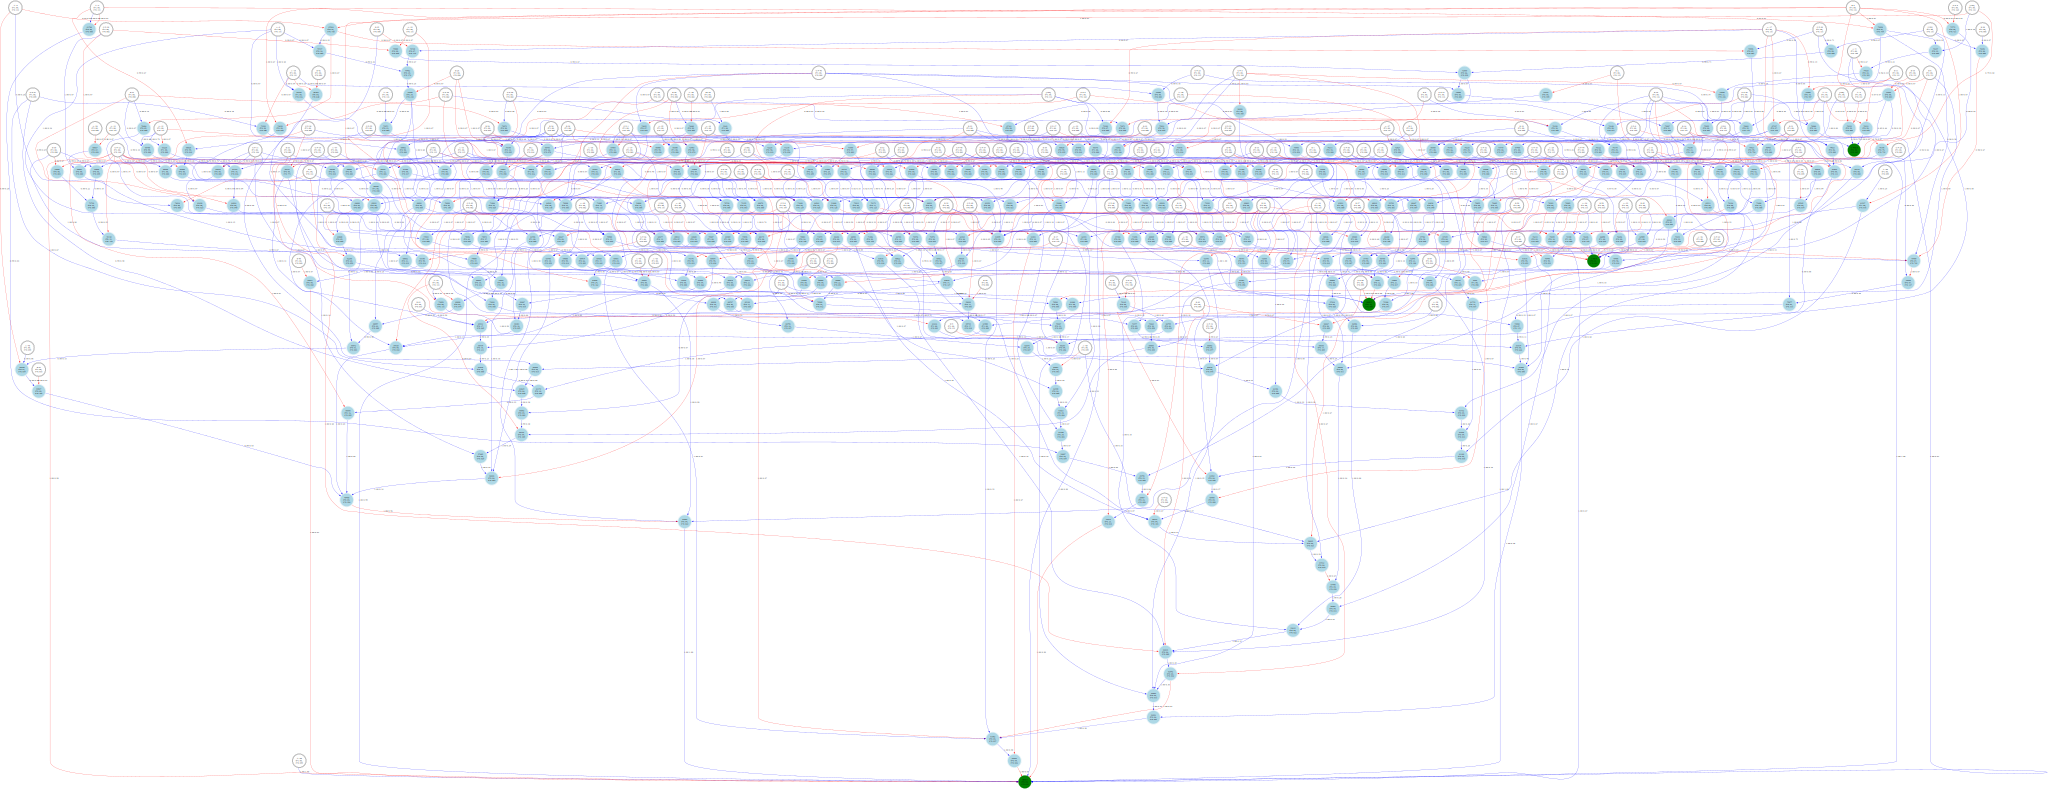

In [260]:
player.play_note.draw()

In [254]:
#player.play_note.draw().render("СЛОН ЗАПОМНИЛ КУЗНЕЧИКА!")

Следующая версия:
Перебираем входы с неверным сигналом.
С вероятностью 1 - signal_quality переходим рекурсивно. Если там неудача, сносим.
Иначе с вероятностью (1 - edge_quality) * signal_quality ставим заглушку. Для этого мы рубим бинарную связь так, чтобы в стаб можно было добавить -1 и профитнуться.
Иначе с вероятностью (1 - edge_quality) сносим ребро.

В конце, если ещё не хватает, можем добавить одну связь, получив ещё 1 или -1. Это финальный результат.

ПОЛНОЕ ОБУЧЕНИЕ НА КУЗНЕЧИКЕ!!!!
Нужно включить forget_info С БАГОЙ. Она преценденты в 2 обращает, а was_right - нет.

In [257]:
player = Player()

In [258]:
limit = 8
neurons = [MEMORY_SIZE + 13]

while limit < 128:#len(kuznechik.notes):
    player.play_note.forget_info()
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons))
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        neurons.append(len(player.play_note.neurons))
               
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8  neurons_at_start:  853
0 
limit:  9  neurons_at_start:  853
1 0 
limit:  10  neurons_at_start:  853
1 1 2 2 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 0 
limit:  11  neurons_at_start:  867
1 2 3 2 3 2 1 2 2 1 2 1 1 1 0 
limit:  12  neurons_at_start:  876
1 2 2 3 3 3 3 2 3 2 1 1 1 1 2 2 1 1 2 0 
limit:  13  neurons_at_start:  877
2 2 5 6 4 4 3 5 2 1 1 1 1 1 3 4 3 2 2 2 2 1 0 
limit:  14  neurons_at_start:  895
0 
limit:  15  neurons_at_start:  895
1 1 1 1 1 0 
limit:  16  neurons_at_start:  893
0 
limit:  17  neurons_at_start:  893
0 
limit:  18  neurons_at_start:  893
0 
limit:  19  neurons_at_start:  893
1 3 3 1 1 5 1 1 1 1 0 
limit:  20  neurons_at_start:  900
0 
limit:  21  neurons_at_start:  900
1 1 1 1 2 3 3 1 0 
limit:  22  neurons_at_start:  910
0 
limit:  23  neurons_at_start:  910
0 
limit:  24  neurons_at_start:  910
0 
limit:  25  neurons_at_start:  910
0 
limit:  26  neurons_at_start:  910
0 
limit:  27  neurons_at_start:  910
2 4 3 5 3 5 5 3 1 3 3 8 6 6 4 5 4 4 2 0 
li

2 3 2 16 24 35 37 20 18 16 34 21 14 33 27 29 23 29 21 22 33 27 34 19 21 24 19 36 36 42 30 36 24 32 25 26 36 32 32 28 31 29 46 66 56 45 51 39 46 45 41 28 33 48 27 53 41 52 35 35 23 26 38 28 34 29 40 49 35 45 38 44 38 38 31 39 32 39 41 45 44 33 62 41 25 44 41 53 20 22 26 37 19 28 27 21 31 23 33 22 27 22 28 42 28 21 26 29 36 48 21 27 27 32 31 39 31 29 34 32 34 36 21 20 16 34 28 25 32 29 21 27 33 24 17 23 21 27 35 22 31 32 22 40 30 36 39 27 37 53 24 57 39 28 37 40 23 25 33 32 32 26 20 28 23 28 25 18 20 18 21 26 27 35 34 33 21 41 36 39 33 43 32 25 40 36 31 29 28 19 13 25 17 16 18 15 24 25 30 38 29 26 38 41 30 32 34 44 41 45 30 33 37 32 44 27 20 35 19 13 13 23 23 31 25 25 27 31 37 31 33 31 34 37 24 32 30 30 40 42 49 29 24 26 28 32 46 29 34 34 42 40 32 21 30 32 42 34 40 31 19 20 24 25 21 26 39 27 27 29 19 18 35 38 20 20 41 34 28 27 27 23 44 47 45 37 34 31 32 24 43 27 29 42 28 22 28 42 35 17 8 19 20 35 36 42 34 43 46 38 45 25 38 25 42 47 42 33 34 29 45 36 72 37 38 31 42 43 47 40 31 32 38 49 52

27 33 23 36 44 26 42 37 31 23 29 21 21 36 32 26 46 30 16 17 28 46 35 36 32 34 32 37 35 44 47 32 19 24 22 22 41 25 19 42 18 26 23 44 27 18 25 22 23 26 32 51 47 31 32 38 16 28 31 22 9 25 18 21 18 16 13 27 37 27 10 12 13 18 28 36 45 33 24 33 16 31 28 15 20 27 37 47 35 40 21 23 40 31 33 38 41 32 30 31 21 28 40 33 45 26 33 33 28 41 40 34 30 30 28 42 37 29 26 35 16 10 17 12 29 27 13 25 31 36 45 37 34 34 34 33 38 27 48 40 38 53 41 41 55 47 47 51 36 19 29 23 36 17 15 30 16 19 27 28 20 34 26 21 34 25 25 28 18 49 22 26 30 21 19 23 36 30 25 12 17 28 35 29 30 26 23 26 28 27 26 30 27 19 14 29 18 20 15 12 11 26 14 12 14 22 21 24 23 32 16 27 16 8 5 19 24 34 49 36 23 26 27 39 24 24 31 19 17 11 20 28 20 18 21 21 17 13 25 31 38 46 18 31 30 42 46 61 33 23 23 23 30 21 21 28 21 10 17 13 8 13 4 6 7 5 17 7 20 21 14 34 49 41 20 28 39 44 39 31 37 42 27 28 36 16 24 57 33 28 37 59 34 48 38 31 51 42 37 27 29 30 29 52 34 32 40 28 26 34 27 26 35 45 28 29 34 38 20 29 32 26 27 46 36 17 45 40 32 39 28 40 46 26 19 33 3

KeyboardInterrupt: 

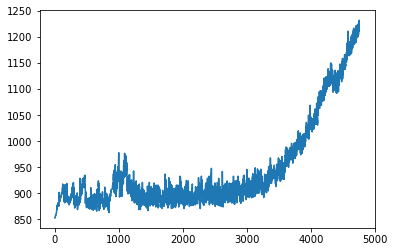

In [259]:
plt.plot(neurons)  # график количества нейронов в эпоху

А вот стандартная процедура (несколько раз проходим по выборке). Ошибка медленно падает, встречается 6. Количество нейронов серийно растёт.

In [210]:
player = Player()

In [211]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    neurons.append(len(player.play_note.neurons))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

92 115 101 91 111 117 93 106 104 104 103 116 95 91 121 102 133 110 102 90 90 104 125 147 113 123 146 126 104 151 126 130 144 132 124 99 124 136 136 118 111 92 119 

KeyboardInterrupt: 

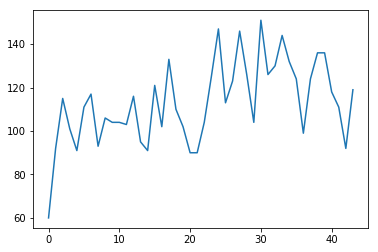

In [212]:
plt.plot(errors)  # график количества ошибок в эпоху

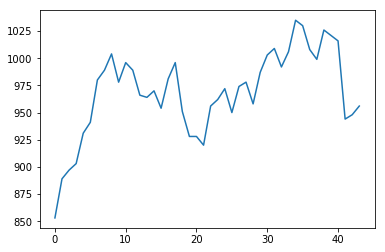

In [213]:
plt.plot(neurons)  # график количества нейронов в эпоху

In [ ]:
player.play_note.draw()

In [18]:
player.play_note.draw().render('fail', view=True) 

'fail.png.png'

СНАЧАЛА БЫ ВЫУЧИТЬ КУЗНЕЧИКА!

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [96]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [98]:
simple_song = Song([12, -1, 11, -1, 9, -1, 8, -1])
result = player.improvise(simple_song)
result.play()

In [99]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [100]:
result.play()

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [130]:
player = Player()

In [131]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [133]:
Songs = []
for i in range(1, 35):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

ERROR! out of range!
ERROR! out of range!
ERROR! out of range!


In [134]:
import random
random.shuffle(Songs)
prev_errors = np.array([1000 for i in range(len(Songs))])

In [135]:
while prev_errors.sum() > 100:
    errors = []
    for song in Songs:
        errors.append(player.learn_to_play(song))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum())

39 64 65 65 42 50 49 70 44 48 48 38 44 55 51 62 50 51 51 47 71 0 0 57 58 42 53 76 40 53 56 42 53 55 42 50 51 58 42 43 52 38 40 26 0 57 55 45 42 48 52 54 65 50 72 49 34 60 44 49 54 36 40 60 48 51 41 52 47 
sum =  3336
35 51 58 57 35 50 39 73 43 47 46 38 43 48 51 60 50 48 50 47 73 0 0 52 59 40 50 73 37 52 56 41 49 53 42 46 51 58 42 40 53 38 40 26 0 58 54 48 41 44 56 51 68 47 72 49 34 58 42 48 54 36 42 59 47 51 40 51 46 
sum =  3236
35 50 57 56 35 50 41 71 41 46 46 39 41 51 51 60 50 45 50 44 73 0 0 52 56 39 52 72 37 51 55 39 51 54 40 44 50 56 42 42 53 38 39 26 0 59 57 44 42 46 54 50 66 50 71 50 35 56 43 48 53 38 41 57 48 51 40 50 46 
sum =  3215
35 53 53 53 34 51 38 72 42 46 46 38 41 50 47 58 51 46 50 45 70 0 0 50 58 38 49 72 37 50 54 40 53 53 40 49 50 57 41 40 50 37 41 26 0 54 55 46 41 46 55 50 65 48 68 46 35 59 42 45 52 36 41 58 46 50 38 52 45 
sum =  3177
36 50 57 52 36 51 39 68 40 45 45 38 40 49 50 59 49 47 49 43 74 0 0 50 56 39 51 72 37 51 55 40 51 52 40 50 50 58 38 41 53 36 41 26 0 

KeyboardInterrupt: 

In [136]:
len(player.play_note.neurons)

1736

In [391]:
simple_song = Song('test/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [279]:
result.save_file("11. Voting Elephant NN cant learn kuznechik (9 errors, 4900 neurons)")

In [392]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [393]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()